## Imports ##

In [1]:
import os
import pickle
import json
import joblib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import mne
# from mne import events_from_annotations, concatenate_raws

from sklearn.model_selection import train_test_split
from scipy.interpolate import CubicSpline
from scipy.integrate import simps
from sklearn.metrics import r2_score

#from imblearn.pipeline import Pipeline
#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF,WhiteKernel,Matern,RationalQuadratic,ExpSineSquared

from sklearn.metrics import classification_report, accuracy_score

from processing.Processing_EEG import process_eeg_raw, process_eeg_epochs
from processing.Processing_NIRS import process_nirs_raw, process_nirs_epochs

from utilities.Read_Data import read_subject_raw_nirs, read_subject_raw_eeg
from utilities.utilities import translate_channel_name_to_ch_id, find_sections, spatial_zscore

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F



## Constants ##

In [2]:
BASE_PATH = '/scratch/mjm9724/stinger/data/'

ROOT_DIRECTORY_EEG = os.path.join(BASE_PATH, 'raw/eeg/')
ROOT_DIRECTORY_NIRS = os.path.join(BASE_PATH, 'raw/nirs/')

# Trial order
TRIAL_TO_CHECK_NIRS = {'VP001': {
                            'nback': ['2016-05-26_007', '2016-05-26_008', '2016-05-26_009',],
                            'gonogo': ['2016-05-26_001', '2016-05-26_002', '2016-05-26_003',],
                            'word': ['2016-05-26_004', '2016-05-26_005', '2016-05-26_006',]
                        },
                        'VP002': {
                            'nback': ['2016-05-26_016', '2016-05-26_017', '2016-05-26_018',],
                            'gonogo': ['2016-05-26_010', '2016-05-26_011', '2016-05-26_012',],
                            'word': ['2016-05-26_013', '2016-05-26_014', '2016-05-26_015',]
                        },
                        'VP003': {
                            'nback': ['2016-05-27_001', '2016-05-27_002', '2016-05-27_003',],
                            'gonogo': ['2016-05-27_007', '2016-05-27_008', '2016-05-27_009',],
                            'word': ['2016-05-27_004', '2016-05-27_005', '2016-05-27_006',]
                        },
                        'VP004': {
                            'nback': ['2016-05-30_001', '2016-05-30_002', '2016-05-30_003'],
                            'gonogo': ['2016-05-30_007', '2016-05-30_008', '2016-05-30_009'],
                            'word': ['2016-05-30_004', '2016-05-30_005', '2016-05-30_006']
                        },
                        'VP005': {
                            'nback': ['2016-05-30_010', '2016-05-30_011', '2016-05-30_012'],
                            'gonogo': ['2016-05-30_016', '2016-05-30_017', '2016-05-30_018'],
                            'word': ['2016-05-30_013', '2016-05-30_014', '2016-05-30_015']
                        },
                        'VP006': {
                            'nback': ['2016-05-31_001', '2016-05-31_002', '2016-05-31_003'],
                            'gonogo': ['2016-05-31_007', '2016-05-31_008', '2016-05-31_009'],
                            'word': ['2016-05-31_004', '2016-05-31_005', '2016-05-31_006']
                        },
                        'VP007': {
                            'nback': ['2016-06-01_001', '2016-06-01_002', '2016-06-01_003'],
                            'gonogo': ['2016-06-01_007', '2016-06-01_008', '2016-06-01_009'],
                            'word': ['2016-06-01_004', '2016-06-01_005', '2016-06-01_006']
                        },
                        'VP008': {
                            'nback': ['2016-06-02_001', '2016-06-02_002', '2016-06-02_003'],
                            'gonogo': ['2016-06-02_007', '2016-06-02_008', '2016-06-02_009'],
                            'word': ['2016-06-02_004', '2016-06-02_005', '2016-06-02_006']
                        },
                        'VP009': {
                            'nback': ['2016-06-02_010', '2016-06-02_011', '2016-06-02_012'],
                            'gonogo': ['2016-06-02_016', '2016-06-02_017', '2016-06-02_018'],
                            'word': ['2016-06-02_013', '2016-06-02_014', '2016-06-02_015']
                        },
                        'VP010': {
                            'nback': ['2016-06-03_001', '2016-06-03_002', '2016-06-03_003'],
                            'gonogo': ['2016-06-03_007', '2016-06-03_008', '2016-06-03_009'],
                            'word': ['2016-06-03_004', '2016-06-03_005', '2016-06-03_006']
                        },
                        'VP011': {
                            'nback': ['2016-06-03_010', '2016-06-03_011', '2016-06-03_012'],
                            'gonogo': ['2016-06-03_016', '2016-06-03_017', '2016-06-03_018'],
                            'word': ['2016-06-03_013', '2016-06-03_014', '2016-06-03_015']
                        },'VP012': {
                            'nback': ['2016-06-06_001', '2016-06-06_002', '2016-06-06_003'],
                            'gonogo': ['2016-06-06_007', '2016-06-06_008', '2016-06-06_009'],
                            'word': ['2016-06-06_004', '2016-06-06_005', '2016-06-06_006']
                        },'VP013': {
                            'nback': ['2016-06-06_010', '2016-06-06_011', '2016-06-06_012'],
                            'gonogo': ['2016-06-06_016', '2016-06-06_017', '2016-06-06_018'],
                            'word': ['2016-06-06_013', '2016-06-06_014', '2016-06-06_015']
                        },'VP014': {
                            'nback': ['2016-06-07_001', '2016-06-07_002', '2016-06-07_003'],
                            'gonogo': ['2016-06-07_007', '2016-06-07_008', '2016-06-07_009'],
                            'word': ['2016-06-07_004', '2016-06-07_005', '2016-06-07_006']
                        },'VP015': {
                            'nback': ['2016-06-07_010', '2016-06-07_011', '2016-06-07_012'],
                            'gonogo': ['2016-06-07_016', '2016-06-07_017', '2016-06-07_018'],
                            'word': ['2016-06-07_013', '2016-06-07_014', '2016-06-07_015']
                        },'VP016': {
                            'nback': ['2016-06-08_001', '2016-06-08_002', '2016-06-08_003'],
                            'gonogo': ['2016-06-08_007', '2016-06-08_008', '2016-06-08_009'],
                            'word': ['2016-06-08_004', '2016-06-08_005', '2016-06-08_006']
                        },'VP017': {
                            'nback': ['2016-06-09_001', '2016-06-09_002', '2016-06-09_003'],
                            'gonogo': ['2016-06-09_007', '2016-06-09_008', '2016-06-09_009'],
                            'word': ['2016-06-09_004', '2016-06-09_005', '2016-06-09_006']
                        },'VP018': {
                            'nback': ['2016-06-10_001', '2016-06-10_002', '2016-06-10_003'],
                            'gonogo': ['2016-06-10_007', '2016-06-10_008', '2016-06-10_009'],
                            'word': ['2016-06-10_004', '2016-06-10_005', '2016-06-10_006']
                        },'VP019': {
                            'nback': ['2016-06-13_001', '2016-06-13_002', '2016-06-13_003'],
                            'gonogo': ['2016-06-13_007', '2016-06-13_008', '2016-06-13_009'],
                            'word': ['2016-06-13_004', '2016-06-13_005', '2016-06-13_006']
                        },'VP020': {
                            'nback': ['2016-06-14_001', '2016-06-14_002', '2016-06-14_003'],
                            'gonogo': ['2016-06-14_007', '2016-06-14_008', '2016-06-14_009'],
                            'word': ['2016-06-14_004', '2016-06-14_005', '2016-06-14_006']
                        },'VP021': {
                            'nback': ['2016-06-14_010', '2016-06-14_011', '2016-06-14_012'],
                            'gonogo': ['2016-06-14_016', '2016-06-14_017', '2016-06-14_018'],
                            'word': ['2016-06-14_013', '2016-06-14_014', '2016-06-14_015']
                        },'VP022': {
                            'nback': ['2016-06-15_001', '2016-06-15_002', '2016-06-15_003'],
                            'gonogo': ['2016-06-15_007', '2016-06-15_008', '2016-06-15_009'],
                            'word': ['2016-06-15_004', '2016-06-15_005', '2016-06-15_006']
                        },'VP023': {
                            'nback': ['2016-06-16_001', '2016-06-16_002', '2016-06-16_003'],
                            'gonogo': ['2016-06-16_007', '2016-06-16_008', '2016-06-16_009'],
                            'word': ['2016-06-16_004', '2016-06-16_005', '2016-06-16_006']
                        },'VP024': {
                            'nback': ['2016-06-16_010', '2016-06-16_011', '2016-06-16_012'],
                            'gonogo': ['2016-06-16_016', '2016-06-16_017', '2016-06-16_018'],
                            'word': ['2016-06-16_013', '2016-06-16_014', '2016-06-16_015']
                        },
                        'VP025': {
                            'nback': ['2016-06-17_010', '2016-06-17_011', '2016-06-17_012',],
                            'gonogo': ['2016-06-17_016', '2016-06-17_017', '2016-06-17_018',],
                            'word': ['2016-06-17_013', '2016-06-17_014', '2016-06-17_015',]
                        },
                        'VP026': {
                            'nback': ['2016-07-11_001', '2016-07-11_002', '2016-07-11_003',],
                            'gonogo': ['2016-07-11_007', '2016-07-11_008', '2016-07-11_009',],
                            'word': ['2016-07-11_004', '2016-07-11_005', '2016-07-11_006',]
                        }
                    }

# Task translation dictionaries
EEG_EVENT_TRANSLATIONS = {
            'nback': {
                'Stimulus/S 16': '0-back target',
                'Stimulus/S 48': '2-back target',
                'Stimulus/S 64': '2-back non-target',
                'Stimulus/S 80': '3-back target',
                'Stimulus/S 96': '3-back non-target',
                'Stimulus/S112': '0-back session',
                'Stimulus/S128': '2-back session',
                'Stimulus/S144': '3-back session'},
            'gonogo': {
                'Stimulus/S 16': 'go',
                'Stimulus/S 32': 'nogo',
                'Stimulus/S 48': 'gonogo session'},
            'word': {
                'Stimulus/S 16': 'verbal_fluency',
                'Stimulus/S 32': 'baseline'}
}
NIRS_EVENT_TRANSLATIONS = {
    'nback': {
        '7.0': '0-back session',
        '8.0': '2-back session',
        '9.0': '3-back session'},
    'gonogo': {
        '3.0': 'gonogo session'},
    'word': {
        '1.0': 'verbal_fluency',
        '2.0': 'baseline'}
}

# Sub tasks to crop times to for same length
TASK_STIMULOUS_TO_CROP = {'nback': ['0-back session', '2-back session', '3-back session'],
                            'gonogo': ['gonogo session'],
                            'word': ['verbal_fluency', 'baseline']
                            }

# EEG Coordinates
EEG_COORDS = {'FP1':(-0.3090,0.9511,0.0001), #Fp1
                'AFF5':(-0.5417,0.7777,0.3163), #AFF5h
                'AFz':(0.0000,0.9230,0.3824),
                'F1':(-0.2888,0.6979,0.6542),
                'FC5':(-0.8709,0.3373,0.3549),
                'FC1':(-0.3581,0.3770,0.8532),
                'T7':(-1.0000,0.0000,0.0000),
                'C3':(-0.7066,0.0001,0.7066),
                'Cz':(0.0000,0.0002,1.0000),
                'CP5':(-0.8712,-0.3372,0.3552),
                'CP1':(-0.3580,-0.3767,0.8534),
                'P7':(-0.8090,-0.5878,-0.0001),
                'P3':(-0.5401,-0.6724,0.5045),
                'Pz':(0.0000,-0.7063,0.7065),
                'POz':(0.0000,-0.9230,0.3824),
                'O1':(-0.3090,-0.9511,0.0000),
                'FP2':(0.3091,0.9511,0.0000), #Fp2
                'AFF6':(0.5417,0.7777,0.3163), #AFF6h
                'F2':(0.2888,0.6979,0.6542),
                'FC2':(0.3581,0.3770,0.8532),
                'FC6':(0.8709,0.3373,0.3549),
                'C4':(0.7066,0.0001,0.7066),
                'T8':(1.0000,0.0000,0.0000),
                'CP2':(0.3580,-0.3767,0.8534),
                'CP6':(0.8712,-0.3372,0.3552),
                'P4':(0.5401,-0.6724,0.5045),
                'P8':(0.8090,-0.5878,-0.0001),
                'O2':(0.3090,-0.9511,0.0000),
                'TP9':(-0.8777,-0.2852,-0.3826),
                'TP10':(0.8777,-0.2853,-0.3826),
                
                'Fp1':(-0.3090,0.9511,0.0001),
                'AFF5h':(-0.5417,0.7777,0.3163),
                'Fp2':(0.3091,0.9511,0.0000),
                'AFF6h':(0.5417,0.7777,0.3163),}

# NIRS Ccoordinates
NIRS_COORDS = {
    'AF7':(-0.5878,0.809,0),
    'AFF5':(-0.6149,0.7564,0.2206),
    'AFp7':(-0.454,0.891,0),
    'AF5h':(-0.4284,0.875,0.2213),
    'AFp3':(-0.2508,0.9565,0.1438),
    'AFF3h':(-0.352,0.8111,0.4658),
    'AF1':(-0.1857,0.915,0.3558),
    'AFFz':(0,0.8312,0.5554),
    'AFpz':(0,0.9799,0.1949),
    'AF2':(0.1857,0.915,0.3558),
    'AFp4':(0.2508,0.9565,0.1437),
    'FCC3':(-0.6957,0.1838,0.6933),
    'C3h':(-0.555,0.0002,0.8306),
    'C5h':(-0.8311,0.0001,0.5552),
    'CCP3':(-0.6959,-0.1836,0.6936),
    'CPP3':(-0.6109,-0.5259,0.5904),
    'P3h':(-0.4217,-0.6869,0.5912),
    'P5h':(-0.6411,-0.6546,0.3985),
    'PPO3':(-0.4537,-0.796,0.3995),
    'AFF4h':(0.352,0.8111,0.4658),
    'AF6h':(0.4284,0.875,0.2212),
    'AFF6':(0.6149,0.7564,0.2206),
    'AFp8':(0.454,0.891,0),
    'AF8':(0.5878,0.809,0),
    'FCC4':(0.6957,0.1838,0.6933),
    'C6h':(0.8311,0.0001,0.5552),
    'C4h':(0.555,0.0002,0.8306),
    'CCP4':(0.6959,-0.1836,0.6936),
    'CPP4':(0.6109,-0.5258,0.5904),
    'P6h':(0.6411,-0.6546,0.3985),
    'P4h':(0.4216,-0.687,0.5912),
    'PPO4':(0.4537,-0.796,0.3995),
    'PPOz':(0,-0.8306,0.5551),
    'PO1':(-0.1858,-0.9151,0.3559),
    'PO2':(0.1859,-0.9151,0.3559),
    'POOz':(0,-0.9797,0.1949)}

# EEG Channels names
EEG_CHANNEL_NAMES = ['FP1', 
                    'AFF5h', 
                    'AFz', 
                    'F1', 
                    'FC5', 
                    'FC1', 
                    'T7', 
                    'C3', 
                    'Cz', 
                    'CP5', 
                    'CP1', 
                    'P7', 
                    'P3', 
                    'Pz', 
                    'POz', 
                    'O1',  
                    'FP2', 
                    'AFF6h',
                    'F2', 
                    'FC2', 
                    'FC6', 
                    'C4', 
                    'T8', 
                    'CP2', 
                    'CP6', 
                    'P4', 
                    'P8', 
                    'O2',
                    'HEOG',
                    'VEOG']

## Parameters - Raw ##

In [3]:
## Subject/Trial Parameters ##
subject_ids = np.arange(1,2) # 1-27
subjects = []
for i in subject_ids:
    subjects.append(f'VP{i:03d}')

tasks = ['nback','gonogo','word']

# NIRS Sampling rate
fnirs_sample_rate = 10
# EEG Downsampling rate
eeg_sample_rate = 10

# Do processing or not
do_processing = True

# Redo preprocessing pickle files, TAKES A LONG TIME 
redo_preprocessing = False

# Redo data formating pickle files, TAKES A LONG TIME
redo_data_formatting = False

## Signal Prediction ##

### Parameters - Signal Prediction

In [4]:
# Time window (seconds)
eeg_t_min = -10
eeg_t_max = 10
nirs_t_min = -10
nirs_t_max = 10

offset_t = 0

# Train/Test Size
train_size = 4000
test_size = 500

# training loop
n_epochs = 100

# Define channels to use
nirs_channels_to_use_base = list(NIRS_COORDS.keys())
use_hbr = False
# nirs_channels_to_use_base = ['AF7','AFF5', 'AFp5h','AFp3','C6h','C4h','CCP4','CPP4']
eeg_channels_to_use = EEG_CHANNEL_NAMES
# eeg_channels_to_use = ['Cz', 'P7']

### Extract Data ###

In [5]:
from scipy.io import loadmat

matlab_eeg = loadmat(os.path.join(BASE_PATH, 'eeg_data_vp001.mat'))
matlab_nirs = loadmat(os.path.join(BASE_PATH, 'oxy_data_vp001.mat'))

eeg_data = matlab_eeg['eeg_block'][0][0].T
nirs_data = matlab_nirs['fnirs_oxy_block_upsampled'][0][0].T

(36, 111185)
(30, 111185)
(20, 4000, 30, 500)


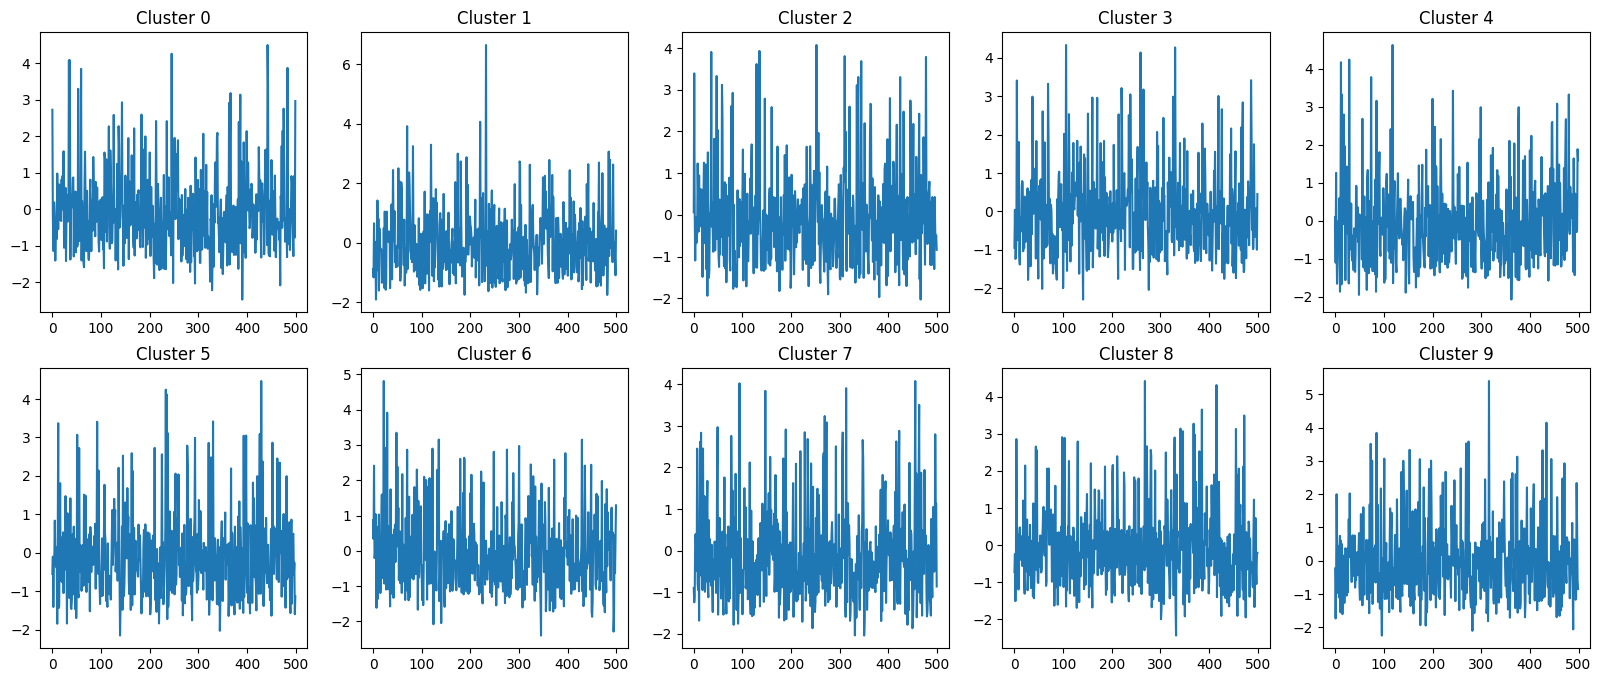

In [6]:
def grab_random_windows(nirs_data, 
                        eeg_data,
                        sampling_rate,
                        nirs_t_min, 
                        nirs_t_max,
                        eeg_t_min, 
                        eeg_t_max,
                        offset_min_t=0,
                        offset_max_t=10,
                        number_of_windows=1000):
    '''make number_of_windows of size t_min to t_max for each offset 0 to offset_t for eeg and nirs'''

    print(nirs_data.shape)
    print(eeg_data.shape)

    nirs_i_min = int(nirs_t_min*sampling_rate)
    nirs_i_max = int(nirs_t_max*sampling_rate)
    eeg_i_min = int(eeg_t_min*sampling_rate)
    eeg_i_max = int(eeg_t_max*sampling_rate)

    offset_min_i = offset_min_t*sampling_rate
    offset_max_i = offset_max_t*sampling_rate

    max_center_eeg = eeg_data.shape[1] - eeg_i_max - offset_max_i
    max_center_nirs = nirs_data.shape[1] - nirs_i_max - offset_max_i
    max_center = np.min([max_center_eeg, max_center_nirs])

    min_center_eeg = np.abs(eeg_i_min + offset_min_i)
    min_center_nirs = np.abs(nirs_i_min + offset_min_i)
    min_center = np.max([min_center_eeg, min_center_nirs])

    nirs_full_windows = []
    eeg_full_windows = []
    for i in range(number_of_windows):
        center_point = np.random.randint(min_center, max_center)
        
        nirs_single_offset_window = []
        eeg_single_offset_window = []
        for offset_t in range(offset_min_t, offset_max_t, 1):
            offset_i = int(offset_t*sampling_rate)

            # EEG
            eeg_low_index = center_point + eeg_i_min + offset_i
            eeg_high_index = center_point + eeg_i_max + offset_i
            eeg_single_offset_window.append(eeg_data[:,eeg_low_index:eeg_high_index])

            # Nirs
            nirs_low_index = center_point + nirs_i_min + offset_i
            nirs_high_index = center_point + nirs_i_max + offset_i
            nirs_single_offset_window.append(nirs_data[:,nirs_low_index:nirs_high_index])

        nirs_full_windows.append(nirs_single_offset_window)
        eeg_full_windows.append(eeg_single_offset_window)
    
    nirs_full_windows = np.array(nirs_full_windows)
    eeg_full_windows = np.array(eeg_full_windows)

    return eeg_full_windows, nirs_full_windows

eeg_windowed_signal_prediction, nirs_windowed_signal_prediction = grab_random_windows(
             nirs_data=nirs_data, 
             eeg_data=eeg_data,
             sampling_rate=200,
             nirs_t_min=nirs_t_min, 
             nirs_t_max=nirs_t_max,
             eeg_t_min=eeg_t_min, 
             eeg_t_max=eeg_t_max,
             offset_min_t=-10,
             offset_max_t=10,
             number_of_windows=500)

eeg_windowed_signal_prediction = eeg_windowed_signal_prediction.transpose(1,3,2,0)
nirs_windowed_signal_prediction = nirs_windowed_signal_prediction.transpose(1,3,2,0)
print(eeg_windowed_signal_prediction.shape)
# plot 10 subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    axs[i//5, i%5].plot(eeg_windowed_signal_prediction[i,0,0,:])
    axs[i//5, i%5].set_title(f'Cluster {i}')
plt.show()

In [7]:
import numpy as np
from scipy.spatial.distance import cdist

# Revised implementation with correct handling of weights without unnecessary transposition
def continuous_correlation2_tensor_looped(X, Y, L, numBins, multipliermethod='multiprod'):
    if X.shape[2] != Y.shape[2]:
        raise ValueError('Columns have to match')
    T = X.shape[2]

    # Create a matrix of weights using Gaussian smoothing
    t_indices = np.arange(1, T + 1)
    bin_centers = np.linspace(1, T, numBins)
    gpMat = np.exp(-cdist(t_indices[:, np.newaxis], bin_centers[:, np.newaxis])**2 / (2 * (L**2) ))

    # Prepare matrices to hold results
    N, M, epochs = X.shape[1], Y.shape[1], X.shape[0]
    covMat = np.zeros((epochs, N, M, numBins))
    corMat = np.zeros((epochs, N, M, numBins))

    for epoch in range(X.shape[0]):
        x_single = X[epoch]
        y_single = Y[epoch]

        covMat_single = np.zeros((N, M, numBins))
        corMat_single = np.zeros((N, M, numBins))
        covMatX_single = np.zeros((N, N, numBins))
        covMatY_single = np.zeros((M, M, numBins))
        # Loop over each bin to calculate covariance and correlation matrices
        for t in range(numBins):
            weight_vector = gpMat[:, t]
            Xgp = x_single * weight_vector.T
            Ygp = y_single * weight_vector.T
            Xmovingavg = np.sum(Xgp, axis=1, keepdims=True) / np.sum(weight_vector, axis=0, keepdims=True)
            Ymovingavg = np.sum(Ygp, axis=1, keepdims=True) / np.sum(weight_vector, axis=0, keepdims=True)
            
            Xgp = Xgp - Xmovingavg * weight_vector.T
            Ygp = Ygp - Ymovingavg * weight_vector.T
            
            covMat_single[:, :, t] = Xgp @ Ygp.T
            covMatX_single[:, :, t] = Xgp @ Xgp.T
            covMatY_single[:, :, t] = Ygp @ Ygp.T
            
            DX = np.sqrt(np.diag(1 / np.diag(covMatX_single[:, :, t])))
            DY = np.sqrt(np.diag(1 / np.diag(covMatY_single[:, :, t])))
            corMat_single[:, :, t] = DX @ covMat_single[:, :, t] @ DY

        covMat[epoch] = covMat_single
        corMat[epoch] = corMat_single

    # Average matrixes across epochs
    corMat = np.mean(corMat, axis=0)
    covMat = np.mean(covMat, axis=0)
    return corMat, covMat

def nancorr(X, Y):
    if X.shape[2] != Y.shape[2]:
        raise ValueError('Columns have to match')

    mX, mY, epochs = X.shape[1], Y.shape[1], X.shape[0]

    full_correlation = np.zeros((epochs, mX, mY))
    for epoch in range(epochs):
        x_single = X[:,:,epoch]
        y_single = Y[:,:,epoch]
        # Normalize X and Y by subtracting the mean and dividing by the standard deviation
        X_norm = (x_single - np.nanmean(x_single, axis=0)) / np.nanstd(x_single, axis=0)
        Y_norm = (y_single - np.nanmean(y_single, axis=0)) / np.nanstd(y_single, axis=0)

        # Compute the correlation matrix by matrix multiplication
        R = np.dot(X_norm.T, Y_norm) / (X.shape[0] - 1)
        full_correlation[epoch] = R

    return R



In [ ]:
import pandas as pd
import seaborn as sns

eeg_full_data = eeg_windowed_signal_prediction.transpose(0,3,2,1)
nirs_full_data = nirs_windowed_signal_prediction.transpose(0,3,2,1)
# for i in range(nirs_full_data.shape[0]):
#     for j in range(nirs_full_data.shape[2]):
#         nirs_full_data[i,:,j,:] = StandardScaler().fit_transform(nirs_full_data[i,:,j,:])

print(eeg_full_data.shape) # (n_epochs, n_channels, n_samples)
print(nirs_full_data.shape) # (n_epochs, n_channels, n_samples)

# Function to plot a heatmap of the correlation matrix
def plot_correlation_heatmap(corMat, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(corMat, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title(title)
    plt.show()

eeg_label_dict = {i:name for i, name in enumerate(eeg_channels_to_use)}
nirs_label_dict = {i:name for i, name in enumerate(nirs_channels_to_use_base)}

guassian_scale = 10  # Length scale for Gaussian
numBins = 10  # Number of bins

# (epochs, offsets, window, channels)
eeg_y = eeg_full_data.transpose(1,0,3,2)
nirs_x = nirs_full_data.transpose(1,0,3,2)
print(eeg_y.shape)
print(nirs_x.shape)
# nirs_x = eeg_y

eeg_channels = eeg_y.shape[3]
nirs_channels = nirs_x.shape[3]

# Plot all channel combinations in a matrix
correlation_dict = {}
v_min = 99999
v_max = 0
for i in range(eeg_channels):
    for j in range(nirs_channels):

        single_channel_eeg = eeg_y[:,:,:,i] # samples, channels, epochs
        single_channel_nirs = nirs_x[:,:,:,j]

        # Get correlation
        # single_correlation_matrix, covariance_matrix = continuous_correlation2_tensor_looped(single_channel_eeg, single_channel_nirs,guassian_scale, numBins)
        # correlation_dict[(i,j)] = single_correlation_matrix[:,:,0]
        # single_correlation_matrix = get_correlation_matrix(single_channel_eeg, single_channel_nirs)
        single_correlation_matrix = nancorr(single_channel_eeg, single_channel_nirs)
        correlation_dict[(i,j)] = single_correlation_matrix

        # Get min and max
        if np.min(single_correlation_matrix) < v_min:
            v_min = np.min(single_correlation_matrix)
        if np.max(single_correlation_matrix) > v_max:
            v_max = np.max(single_correlation_matrix)

    if i % 5 == 0:
        print(f'finished {i} eeg channels:{eeg_label_dict[0]}-{eeg_label_dict[i]}')

fig, axes = plt.subplots(eeg_channels, nirs_channels, sharex=True, sharey=True,figsize=(360,300)) # 360, 300
for i in range(eeg_channels):
    for j in range(nirs_channels):
        correlation = correlation_dict[(i,j)]
        # sns.heatmap(correlation, ax=axes[i,j], annot=False, cmap='coolwarm', center=0, vmin=-1, vmax=1)

        axes[i, j].imshow(correlation, cmap='coolwarm', interpolation='nearest', vmin=v_min, vmax=v_max)
        plt.setp(axes[i, j], aspect=1.0, adjustable='box')

fig.subplots_adjust(wspace=0)
# label axis
for ax, col in zip(axes[0], nirs_label_dict.values()):
    ax.set_title(col)

for ax, row in zip(axes[:,0], eeg_label_dict.values()):
    ax.set_ylabel(row, rotation=0, size='large')
# fig.subplots_adjust(.1,.1,.9,.9,0,0)
 
plt.gca().set_yticks(np.arange(0,22,2))
plt.gca().set_xticks(np.arange(0,22,2))
plt.gca().set_yticklabels(np.arange(-10, 12, 2))
plt.gca().set_xticklabels(np.arange(-10, 12, 2))

plt.tight_layout()

cbar = fig.colorbar(axes[0,0].imshow(correlation, cmap='coolwarm', interpolation='nearest', vmin=v_min, vmax=v_max), ax=axes, shrink=0.6)
path = 'final_1_subject_matlab_correlation_matrix.png'
plt.savefig(path)
plt.show()

(20, 500, 30, 4000)
(20, 500, 36, 4000)
(500, 20, 4000, 30)
(500, 20, 4000, 36)
finished 0 eeg channels:FP1-FP1
finished 5 eeg channels:FP1-FC1
finished 10 eeg channels:FP1-CP1
finished 15 eeg channels:FP1-O1
finished 20 eeg channels:FP1-FC6
finished 25 eeg channels:FP1-P4


### EEG Decoder/Encoder ###

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
sdasdasd=asdasd
# Define the Encoder part of the VAE
# class EEG_Encoder(nn.Module):
#     def __init__(self, input_dim, hidden_dim1, hidden_dim2, latent_dim, dropout_rate):
#         super(EEG_Encoder, self).__init__()
#         self.rnn = nn.GRU(input_dim, hidden_dim2, batch_first=True)
#         self.mu = nn.Linear(hidden_dim2, latent_dim)
#         self.log_var = nn.Linear(hidden_dim2, latent_dim)

#         print(f'input_dim: {input_dim}')
#         print(f'hidden_dim1: {hidden_dim1}')
#         print(f'hidden_dim2: {hidden_dim2}')
#         print(f'latent_dim: {latent_dim}')
#         print(f'dropout_rate: {dropout_rate}')
        
#     def forward(self, x):
#         _, h_n = self.rnn(x)  # h_n is the last hidden state
#         h_n = h_n.squeeze(0)  # Remove the first dimension for batch
#         return self.mu(h_n), self.log_var(h_n)

# Define the Decoder part of the VAE
# class EEG_Decoder(nn.Module):
#     def __init__(self, latent_dim, hidden_dim, output_dim, sequence_length):
#         super(EEG_Decoder, self).__init__()
#         self.rnn = nn.GRU(latent_dim, hidden_dim, batch_first=True)
#         self.out = nn.Linear(hidden_dim, output_dim)
#         self.sequence_length = sequence_length

#         print(f'latent_dim: {latent_dim}')
#         print(f'hidden_dim: {hidden_dim}')
#         print(f'output_dim: {output_dim}')
#         print(f'sequence_length: {sequence_length}')

#     def forward(self, z):
#         # Repeat z to match the sequence length
#         # z = z.unsqueeze(1).repeat(1, self.sequence_length, 1)
#         # output, _ = self.rnn(z)

#         z = z.unsqueeze(1).repeat(1, self.sequence_length, 1)
#         output, _ = self.rnn(z)
#         # We take the output of the last LSTM time step
#         output = self.out(output[:, -1, :])

#         return torch.sigmoid(output)

# # Define the full VAE
# class VAE(nn.Module):
#     def __init__(self, input_dim, hidden_dim1, hidden_dim2, latent_dim, output_dim, sequence_length, dropout_rate):
#         super(VAE, self).__init__()
#         self.encoder = EEG_Encoder(input_dim, hidden_dim1, hidden_dim2, latent_dim, dropout_rate)
#         self.decoder = EEG_Decoder(latent_dim, hidden_dim2, output_dim, sequence_length)

#     def reparameterize(self, mu, log_var):
#         std = torch.exp(0.5 * log_var)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def forward(self, x):
#         mu, log_var = self.encoder(x)
#         z = self.reparameterize(mu, log_var)
#         reconstruction = self.decoder(z)
#         return reconstruction, mu, log_var

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.linear = nn.Linear(input_dim, 128)
        self.mu = nn.Linear(128, latent_dim)
        self.log_var = nn.Linear(128, latent_dim)

    def reparameterize(self, x):
        self.latent_mean = self.mu(x)
        self.latent_log_var = self.log_var(x)

        if self.training:
            std = torch.exp(0.5 * self.latent_log_var)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(self.latent_mean)
        else:
            return self.latent_mean

    def forward(self, x):
        x=self.linear(x)
        x = torch.relu(x)
        z = self.reparameterize(x)

        return z, self.latent_mean, self.latent_log_var

# Define the Decoder part of the VAE
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.linear = nn.Linear(latent_dim, 128)
        self.out = nn.Linear(128, output_dim)

    def forward(self, z):
        z = torch.relu(self.linear(z))
        return torch.sigmoid(self.out(z))  # Using sigmoid for normalization

# Define the full VAE
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, latent_dim, output_dim, dropout_rate):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, output_dim)

        print(f'input_dim: {input_dim}')
        print(f'latent_dim: {latent_dim}')
    
    def forward(self, x):
        z, latent_mean, latent_log_var = self.encoder(x)
        return self.decoder(z), latent_mean, latent_log_var

In [ ]:
full_data = eeg_windowed_signal_prediction.copy()
print(full_data.shape)

test_size = int(full_data.shape[0] * 0.1)
train_size = full_data.shape[0] - test_size

# Train
# Assuming x_train contains the EEG data
# scaler = StandardScaler()  # or MinMaxScaler(feature_range=(0, 1))
# x_train_scaled = scaler.fit_transform(full_data.reshape(-1, 1))
# full_data = x_train_scaled.reshape(full_data.shape)

# add single dimension to match the input shape of the model
eeg_data_train = full_data[:train_size, 0]
eeg_data_train = np.expand_dims(eeg_data_train, axis=1)

print(f'x_train: {eeg_data_train.shape}')

# plot 10 subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    plot_index = i*100
    axs[i//5, i%5].plot(eeg_data_train[plot_index:plot_index+100, 0])
    axs[i//5, i%5].set_title(f'Cluster {i}')
plt.show()


In [ ]:
class CCALoss(nn.Module):
    def forward(self, X, Y):
        # Center the variables
        X = X - X.mean(0)
        Y = Y - Y.mean(0)

        # Compute covariance matrices
        covariance_XX = X.t().mm(X) / (X.size(0) - 1)
        covariance_YY = Y.t().mm(Y) / (Y.size(0) - 1)
        covariance_XY = X.t().mm(Y) / (X.size(0) - 1)

        # Solve the generalized eigenvalue problem for CCA
        inv_XX = torch.linalg.inv(covariance_XX)
        inv_YY = torch.linalg.inv(covariance_YY)
        matrix = inv_XX.mm(covariance_XY).mm(inv_YY).mm(covariance_XY.t())

        # Use torch to get the eigenvalues
        cca_loss = -torch.linalg.eigvals(matrix).abs().sum()
        return cca_loss
    
class CorrelationLoss(nn.Module):
    def __init__(self):
        super(CorrelationLoss, self).__init__()
        self.epsilon = 1e-8  # Small constant to avoid division by zero

    def forward(self, x, y):
        x_mean = x - x.mean(dim=0, keepdim=True)
        y_mean = y - y.mean(dim=0, keepdim=True)
        
        # Calculate the standard deviations, adding epsilon for numerical stability
        x_std = x.std(dim=0, keepdim=True) + self.epsilon
        y_std = y.std(dim=0, keepdim=True) + self.epsilon

        # Compute the covariance between x and y
        covariance = (x_mean * y_mean).mean(dim=0)

        # Compute the correlation matrix and then the mean of the correlation coefficients
        correlation_matrix = covariance / (x_std * y_std)
        correlation_loss = 1 - correlation_matrix.mean()  # We aim to maximize correlation, hence minimize (1 - corr)
        return correlation_loss

# Adding a simple contrastive loss component
def contrastive_loss_2(z, participants, temporal_ids, alpha=0.1):
    """
    A simple contrastive loss that encourages closer encoding for similar conditions.
    """
    n = z.size(0)
    loss = 0.0
    count = 0

    # Simple pairwise loss: for each pair in the batch
    for i in range(n):
        for j in range(i + 1, n):
            # Calculate the Euclidean distance between two latent vectors
            latent_dist = F.pairwise_distance(z[i].unsqueeze(0), z[j].unsqueeze(0))

            # Determine if they are from the same participant
            same_participant = participants[i] == participants[j]

            # Calculate distance between two vectors
            # spatial_dist = F.pairwise_distance(spatial_coordinates[i].unsqueeze(0), spatial_coordinates[j].unsqueeze(0))
            temporal_dist = torch.abs(temporal_ids[i] - temporal_ids[j])

            # Calculate a combined spatial-temporal weight
            # Larger spatial or temporal distances increase the desired separation in the latent space
            weight = torch.exp(-alpha * temporal_dist)

            # Loss contribution depends on whether pairs are from the same participant
            if same_participant:
                # Minimize the latent distance for similar conditions
                loss += weight * latent_dist
            else:
                # Maximize the latent distance for different conditions, ensuring at least some minimal separation
                loss += weight * F.relu(1.0 - latent_dist)

            count += 1

    return loss / count if count > 0 else 0

In [ ]:
# Train
eeg_y_train = torch.from_numpy(eeg_data_train).float()
eeg_x_train = torch.from_numpy(eeg_data_train).float()

# Get meta data from features  # EEG data needs to be float
participants = torch.tensor(eeg_meta_data_dict['participant_id'][:train_size], dtype=torch.long)  # Participant IDs as long integers
# spatial_distances = torch.tensor(spatial_distances, dtype=torch.float32)  # Continuous data
temporal_distances = torch.tensor(eeg_meta_data_dict['temporal_id'][:train_size], dtype=torch.long)
# Stack participant and distance information along the second dimension
meta_data = torch.stack([participants, temporal_distances], dim=1)

print(f'x_train: {eeg_x_train.shape}')
print(f'y_train: {eeg_y_train.shape}')
print(f'meta_data: {meta_data.shape}')

# Stack participant and distance information along the second dimension
train_dataset = TensorDataset(eeg_x_train, eeg_y_train, meta_data)
train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)

# Assuming each EEG window is flattened into a vector
input_dim = eeg_x_train.shape[1] # number of features in each time point
latent_dim = 50  # Size of the latent vector

# Create the model, optimizer, and loss function
eeg_model = VAE(input_dim, 
                hidden_dim1=128,
                hidden_dim2=64, 
                latent_dim=latent_dim, 
                output_dim=input_dim,
                dropout_rate=0.2)

# from torchmetrics.functional import r2_score
from torchmetrics.regression import R2Score

optimizer = optim.Adam(eeg_model.parameters(), lr=0.01)
# reconstruction_loss = nn.MSELoss()
# reconstruction_loss = R2Score(num_outputs=sequence_length)
reconstruction_loss = nn.MSELoss(size_average=False)

# Modify the training loop to include the contrastive loss
def train(epoch):
    eeg_model.train()
    train_loss = 0
    for batch_idx, (data, targets, meta_data) in enumerate(train_loader):
        # data = data.to(device)
        optimizer.zero_grad()
        reconstructed, mu, log_var = eeg_model(data)
        
        # recon_loss = F.mse_loss(reconstructed, targets, reduction='sum')
        # recon_loss = torch.abs(1-reconstruction_loss(targets, reconstructed))

        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        recon_loss = reconstruction_loss(reconstructed, data)

        # Assume targets contain [participants, spatial_distances, temporal_distances]
        participants = meta_data[:,0]
        temporal_distances = meta_data[:, 1]
        # spatial_distances = meta_data[:, 2]

        # cont_loss = contrastive_loss(mu, participants, temporal_distances)

        # Combine the losses
        loss = recon_loss + kl_loss
        loss.backward()

        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    return eeg_model


# Example of training the model for 5 epochs
for epoch in range(1, 10):
    eeg_model = train(epoch)

eeg_encoder = eeg_model.encoder
eeg_decoder = eeg_model.decoder

In [ ]:
# nirs_full_data = nirs_windowed_signal_prediction.copy()
# 0,1,2 -> 0,2,1
nirs_full_data = nirs_windowed_signal_prediction.transpose(0,2,1)

print(nirs_full_data.shape)# epochs, window, channels

# scale for each channel
for i in range(nirs_full_data.shape[2]):
    nirs_full_data[:,:,i] = StandardScaler().fit_transform(nirs_full_data[:,:,i])

# Train
nirs_data_train = nirs_full_data[:train_size]

# plot 10 subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    axs[i//5, i%5].plot(nirs_full_data[i])
    axs[i//5, i%5].set_title(f'Cluster {i}')
plt.show()

nirs_x_train = torch.from_numpy(nirs_data_train).float()

print(f'x_train: {nirs_x_train.shape}')
print(f'eeg_x_train {eeg_x_train.shape}')

# Get meta data from features  # EEG data needs to be float
nirs_participants = torch.tensor(nirs_meta_data_dict['participant_id'][:train_size], dtype=torch.long)  # Participant IDs as long integers
# spatial_distances = torch.tensor(spatial_distances, dtype=torch.float32)  # Continuous data
nirs_temporal_distances = torch.tensor(nirs_meta_data_dict['temporal_id'][:train_size], dtype=torch.long)
# Stack participant and distance information along the second dimension
nirs_meta_data = torch.stack([nirs_participants, nirs_temporal_distances], dim=1)

# Random data for testing
# nirs_x_train = torch.randn(nirs_x_train.shape)
# nirs_x_train = eeg_x_train

# Stack participant and distance information along the second dimension
nirs_train_dataset = TensorDataset(nirs_x_train, nirs_x_train, nirs_meta_data)
encoder_alignment_train_dataset = TensorDataset(nirs_x_train, eeg_x_train, nirs_meta_data)

In [ ]:
from timeseries_clustering_vae.vrae.vrae import VRAE
from sklearn.preprocessing import StandardScaler, MinMaxScaler

hidden_size = 90
hidden_layer_depth = 1
latent_length = 50
batch_size = 500
learning_rate = 0.0005
n_epochs = 20
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=30
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

sequence_length = nirs_x_train.shape[1]
number_of_features = nirs_x_train.shape[2]
print(nirs_x_train.shape)

nirs_vrae = VRAE(sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block)

nirs_vrae.fit(nirs_train_dataset)



In [ ]:
nirs_test_data = nirs_full_data[train_size:train_size+test_size]

print(nirs_test_data.shape)

# Predict signal
nirs_x_test = torch.from_numpy(nirs_test_data).float()
test_dataset = TensorDataset(nirs_x_test, nirs_x_test)
nirs_predicted_eeg = nirs_vrae.reconstruct(test_dataset).transpose(1,0,2)

epoch_to_plot = 1
size = 100

In [ ]:
print(nirs_test_data.shape)
print(nirs_predicted_eeg.shape)

epoch_to_plot = 1

from sklearn.metrics import r2_score
# for each channel (7)
for i in range(nirs_test_data.shape[2]):
    r2_nirs = r2_score(nirs_test_data[epoch_to_plot,:,i], nirs_predicted_eeg[epoch_to_plot,:,i])
    print(f'nirs {i} r2: {r2_nirs}')

# Plot the fnirs predicted vs eeg predicted vs real EEG signal on subplots
# plots should be for each channel 7,2
fig, axs = plt.subplots(7, 2, figsize=(20, 8))
for i in range(7):
    axs[i, 0].plot(nirs_predicted_eeg[epoch_to_plot,:,i])
    axs[i, 0].set_title(f'Predicted NIRS {i}')
    axs[i, 1].plot(nirs_test_data[epoch_to_plot,:,i])
    axs[i, 1].set_title(f'Real NIRS {i}')

plt.show()

In [ ]:
nirs_latents = nirs_vrae.transform(encoder_alignment_train_dataset)
nirs_latents = torch.from_numpy(nirs_latents).float()
print(nirs_latents.shape)
print(eeg_x_train.shape)
print(nirs_meta_data.shape)

latent_train_dataset = TensorDataset(nirs_latents, eeg_x_train[:nirs_latents.shape[0]], nirs_meta_data[:nirs_latents.shape[0]])

print(nirs_latents.shape)

In [ ]:
# Aligning the fNIRS encoder
def train_nirs_encoder(mapping_model, optimizer, eeg_encoder, nirs_vrae, train_loader, num_epochs=10):
    nirs_vrae.eval() # Make sure the NIRS encoder does not train 
    eeg_encoder.eval()  # Make sure the EEG encoder does not train   
    mapping_model.train()

    # loss_fn = torch.nn.MSELoss()
    # loss_fn = CCALoss()
    # loss_fn = nn.MSELoss()
    loss_fn = CorrelationLoss()
    train_loss = 0
    for epoch in range(num_epochs):
        for batch_idx, (nirs_latents, eeg_data, meta_data) in enumerate(train_loader):  # Assume loader gives EEG and corresponding fNIRS data
            optimizer.zero_grad()

            with torch.no_grad():
                eeg_latents, eeg_mu, eeg_log_var = eeg_encoder(eeg_data)
            # nirs_latents = nirs_vrae.transform(fnirs_data)

            # Forward pass through the mapping model
            predicted_EEG_latent = mapping_model(nirs_latents)

            # Loss calculation (e.g., MSE)
            loss = loss_fn(predicted_EEG_latent, eeg_latents)
            
            loss.backward()
            train_loss += loss.item()

            optimizer.step()
            if batch_idx % 10 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * nirs_latents.shape[0]}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / nirs_latents.shape[0]:.6f}')
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    return mapping_model


mapping_model = nn.Linear(latent_length, latent_dim)
optimizer = optim.Adam(mapping_model.parameters(), lr=0.005)

num_epochs = 20
batch_size = 500

print(f'NIRS latents: {latent_length} EEG latents: {latent_dim}')
latent_train_loader = DataLoader(latent_train_dataset, batch_size=batch_size, shuffle=True)

mapping_model = train_nirs_encoder(mapping_model, optimizer, eeg_encoder, nirs_vrae, latent_train_loader, num_epochs=n_epochs)


In [ ]:
def predict_eeg_from_nirs(nirs_vrae, eeg_decoder, mapping_model, fnirs_data):
    nirs_vrae.eval()
    eeg_decoder.eval()
    mapping_model.eval()
    
    with torch.no_grad():
        nirs_latents = nirs_vrae.transform(fnirs_data)
        nirs_latents = torch.from_numpy(nirs_latents).float()
        print(nirs_latents.shape)
        eeg_latents = mapping_model(nirs_latents)
        print(eeg_latents.shape)
        predicted_eeg = eeg_decoder(eeg_latents)
    return nirs_latents.numpy(), predicted_eeg.numpy()

def predict_eeg_from_eeg(eeg_encoder, eeg_decoder, eeg_data):
    eeg_encoder.eval()
    eeg_decoder.eval()
    with torch.no_grad():
        eeg_z, latent_mean, latent_log_var = eeg_encoder(eeg_data)
        predicted_eeg = eeg_decoder(eeg_z)
    return eeg_z.numpy(), predicted_eeg.numpy()

nirs_test_data = nirs_full_data[train_size:train_size+test_size]

eeg_test_data = full_data[train_size:train_size+test_size,0]
eeg_test_data = np.expand_dims(eeg_test_data, axis=1)

# Predict signal
nirs_x_test = torch.from_numpy(nirs_test_data).float()
test_dataset = TensorDataset(nirs_x_test, nirs_x_test)
nirs_latents, nirs_predicted_eeg = predict_eeg_from_nirs(nirs_vrae, eeg_decoder, mapping_model, test_dataset)

eeg_test = torch.from_numpy(eeg_test_data).float()
eeg_latents, eeg_predicted_eeg = predict_eeg_from_eeg(eeg_encoder, eeg_decoder, eeg_test)
print(eeg_test.shape)

epoch_to_plot = 1
size = 100

print(eeg_test_data.shape)
print(eeg_predicted_eeg.shape)
print(nirs_predicted_eeg.shape)

from sklearn.metrics import r2_score
r2_nirs = r2_score(eeg_test_data[epoch_to_plot:epoch_to_plot+size], nirs_predicted_eeg[epoch_to_plot:epoch_to_plot+size])
r2_eeg = r2_score(eeg_test_data[epoch_to_plot:epoch_to_plot+size], eeg_predicted_eeg[epoch_to_plot:epoch_to_plot+size])
print(f'nirs r2: {r2_nirs}, eeg r2: {r2_eeg}')

# Plot the fnirs predicted vs eeg predicted vs real EEG signal on subplots
fig, axs = plt.subplots(3)
axs[0].plot(nirs_predicted_eeg[epoch_to_plot:epoch_to_plot+size], label='Predicted EEG NIRS')
axs[0].legend()
axs[1].plot(eeg_predicted_eeg[epoch_to_plot:epoch_to_plot+size], label='Predicted EEG EEG')
axs[1].legend()
axs[2].plot(eeg_test_data[epoch_to_plot:epoch_to_plot+size], label='Real EEG')
axs[2].legend()
plt.show()

### CCA Projection

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

from plotly.graph_objs import *
import plotly

from random import randint


def plot_clustering_matplotlib(z_run, labels, show=True, axes=None, title=''):

    labels = labels[:z_run.shape[0]] # because of weird batch_size

    hex_colors = []
    for _ in np.unique(labels):
        hex_colors.append('#%06X' % randint(0, 0xFFFFFF))

    colors = [hex_colors[int(i)] for i in labels]

    z_run_pca = TruncatedSVD(n_components=3).fit_transform(z_run)
    z_run_tsne = TSNE(perplexity=80, min_grad_norm=1E-12, n_iter=3000).fit_transform(z_run)

    if axes is None or len(axes) < 2:
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    axes[0].scatter(z_run_pca[:, 0], z_run_pca[:, 1], c=colors, marker='*', linewidths=0)
    axes[0].set_title(f'{title} PCA on z_run')

    axes[1].scatter(z_run_tsne[:, 0], z_run_tsne[:, 1], c=colors, marker='*', linewidths=0)
    axes[1].set_title(f'{title} TSNE on z_run')
    if show:
        plt.show()
    
    return axes
    


In [ ]:
import numpy as np
from sklearn.cross_decomposition import CCA

print(eeg_y.shape)
print(nirs_x.shape)

y = eeg_y[:100,10,2000:2100,0] # epochs, 0 offset, 0 center, channels
x = nirs_x[:100,10,:1000,:] # epochs, 0 offset, window, channels

y = np.expand_dims(y, axis=2)

print(y.shape)
print(x.shape)

# Reshape the data
y_reshaped = y.reshape(y.shape[0], -1)  # Reshape to (epochs, window * EEG features)
x_reshaped = x.reshape(x.shape[0], -1)  # Reshape to (epochs, window * fNIRS features)

# Standardize the data
scaler_y = StandardScaler()
scaler_x = StandardScaler()
y_standard = scaler_y.fit_transform(y_reshaped)
x_standard = scaler_x.fit_transform(x_reshaped)

# Define the number of components
cca = CCA(n_components=10)

# Fit and transform the data
y_c, x_c = cca.fit_transform(y_standard, x_standard)

print(y_c.shape)
print(x_c.shape)

# y_c and x_c are the projections of the original EEG and fNIRS data into the shared latent space

In [ ]:
label = 0
fake_labels = np.zeros((x_c.shape[0]), dtype=int)
for i in range(0, x_c.shape[0], 10):
    for j in range(10):
        fake_labels[i+j] = label
    label += 1

# plot x and y latents side by side
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
plot_clustering_matplotlib(x_c, fake_labels, show=False, axes=axes[0], title='fNIRS')
plot_clustering_matplotlib(y_c, fake_labels, show=False, axes=axes[1], title='EEG')
plt.show()

In [ ]:
fake_labels = [0] * eeg_latents.shape[0]
plot_clustering(eeg_latents, fake_labels, engine='matplotlib', download = False)

In [ ]:
fake_labels = [0] * nirs_latents.shape[0]
plot_clustering(nirs_latents, fake_labels, engine='matplotlib', download = False)

In [ ]:

class LSTMModel(nn.Module):
    def __init__(self, sequence_length, number_of_features, hidden_dim, output_steps, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=number_of_features, hidden_size=hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_dim, output_steps)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        predictions = self.linear(lstm_out[:,-1,:])
        return predictions

def train_nirs_to_eeg_lstm(model, train_loader, num_epochs=10):
    model.train()

    # loss_fn = torch.nn.MSELoss()
    # loss_fn = CCALoss()
    # loss_fn = CorrelationLoss()
    loss_function = nn.MSELoss()
    train_loss = 0
    for epoch in range(num_epochs):
        for batch_idx, (nirs_data, eeg_data) in enumerate(train_loader):  # Assume loader gives EEG and corresponding fNIRS data
            optimizer.zero_grad()

            # Forward pass
            predictions = model(nirs_data)
            
            # Compute loss
            loss = loss_function(predictions, eeg_data)
            
            loss.backward()
            train_loss += loss.item()

            optimizer.step()
            if batch_idx % 10 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * nirs_data.shape[0]}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / nirs_data.shape[0]:.6f}')
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    return model

print(nirs_x_train.shape)
print(eeg_x_train.shape)
lstm_dataset = TensorDataset(nirs_x_train, eeg_x_train)
    
number_of_features = nirs_x_test.shape[2]
sequence_length = nirs_x_test.shape[1]
output_steps = eeg_x_train.shape[1]
hidden_dim = 128  # Number of LSTM units
batch_size = 500

model = LSTMModel(sequence_length=sequence_length, number_of_features=number_of_features, hidden_dim=hidden_dim, output_steps=output_steps)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

dataloader = DataLoader(lstm_dataset, batch_size=batch_size, shuffle=True)

loss_function = nn.MSELoss()

lstm_model = train_nirs_to_eeg_lstm(model, dataloader, num_epochs=3)

In [ ]:
def predict_eeg_from_nirs_lstm(model, nirs_data):
    model.eval()
    with torch.no_grad():
        predicted_eeg = model(nirs_data)
    return predicted_eeg.numpy()

nirs_test_data = nirs_full_data[train_size:train_size+test_size]

eeg_test_data = full_data[train_size:train_size+test_size,0]
eeg_test_data = np.expand_dims(eeg_test_data, axis=1)

# Predict signal
nirs_x_test = torch.from_numpy(nirs_test_data).float()

nirs_predicted_eeg_lstm = predict_eeg_from_nirs_lstm(lstm_model, nirs_x_test)

epoch_to_plot = 1
size = 100

print(eeg_test_data.shape)
print(nirs_predicted_eeg_lstm.shape)

from sklearn.metrics import r2_score
r2_eeg = r2_score(eeg_test_data[epoch_to_plot:epoch_to_plot+size], nirs_predicted_eeg_lstm[epoch_to_plot:epoch_to_plot+size])
print(f'nirs r2: {r2_nirs}')

# Plot the fnirs predicted vs eeg predicted vs real EEG signal on subplots
fig, axs = plt.subplots(2)
axs[0].plot(nirs_predicted_eeg_lstm[epoch_to_plot:epoch_to_plot+size], label='Predicted EEG NIRS LSTM')
axs[0].legend()
axs[1].plot(eeg_test_data[epoch_to_plot:epoch_to_plot+size], label='Real EEG')
axs[1].legend()
plt.show()

In [ ]:
sasd=asdasdasd

### Old stuff ###

In [ ]:

asdas=dasdasdas
class NIRS_Encoder(nn.Module):
    """
    Encoder network containing enrolled LSTM/GRU

    :param number_of_features: number of input features
    :param hidden_size: hidden size of the RNN
    :param hidden_layer_depth: number of layers in RNN
    :param latent_length: latent vector length
    :param dropout: percentage of nodes to dropout
    :param block: LSTM/GRU block
    """
    def __init__(self, number_of_features, hidden_size, hidden_layer_depth, latent_length, dropout, block = 'LSTM'):

        super(NIRS_Encoder, self).__init__()

        self.number_of_features = number_of_features
        self.hidden_size = hidden_size
        self.hidden_layer_depth = hidden_layer_depth
        self.latent_length = latent_length

        if block == 'LSTM':
            self.model = nn.LSTM(self.number_of_features, self.hidden_size, self.hidden_layer_depth, dropout = dropout)
        elif block == 'GRU':
            self.model = nn.GRU(self.number_of_features, self.hidden_size, self.hidden_layer_depth, dropout = dropout)
        else:
            raise NotImplementedError

    def forward(self, x):
        """Forward propagation of encoder. Given input, outputs the last hidden state of encoder

        :param x: input to the encoder, of shape (sequence_length, batch_size, number_of_features)
        :return: last hidden state of encoder, of shape (batch_size, hidden_size)
        """
        _, (h_end, c_end) = self.model(x)
        h_end = h_end[-1, :, :]
        return h_end


class NIRS_Lambda(nn.Module):
    """Lambda module converts output of encoder to latent vector

    :param hidden_size: hidden size of the encoder
    :param latent_length: latent vector length
    """
    def __init__(self, hidden_size, latent_length):
        super(NIRS_Lambda, self).__init__()

        self.hidden_size = hidden_size
        self.latent_length = latent_length

        self.hidden_to_mean = nn.Linear(self.hidden_size, self.latent_length)
        self.hidden_to_logvar = nn.Linear(self.hidden_size, self.latent_length)

        nn.init.xavier_uniform_(self.hidden_to_mean.weight)
        nn.init.xavier_uniform_(self.hidden_to_logvar.weight)


        # self.bn_mean = nn.BatchNorm1d(latent_length)
        # self.bn_logvar = nn.BatchNorm1d(latent_length)

    def forward(self, cell_output):
        """Given last hidden state of encoder, passes through a linear layer, and finds the mean and variance

        :param cell_output: last hidden state of encoder
        :return: latent vector
        """

        self.latent_mean = self.hidden_to_mean(cell_output)
        self.latent_logvar = self.hidden_to_logvar(cell_output)

        # self.latent_mean = self.bn_mean(self.latent_mean)
        # self.latent_logvar = self.bn_logvar(self.latent_logvar)

        if self.training:
            std = torch.exp(0.5 * self.latent_logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(self.latent_mean)
        else:
            return self.latent_mean

class NIRS_VRAE(BaseEstimator, nn.Module):
    """Variational recurrent auto-encoder. This module is used for dimensionality reduction of timeseries

    :param sequence_length: length of the input sequence
    :param number_of_features: number of input features
    :param hidden_size:  hidden size of the RNN
    :param hidden_layer_depth: number of layers in RNN
    :param latent_length: latent vector length
    :param batch_size: number of timeseries in a single batch
    :param learning_rate: the learning rate of the module
    :param block: GRU/LSTM to be used as a basic building block
    :param n_epochs: Number of iterations/epochs
    :param dropout_rate: The probability of a node being dropped-out
    :param optimizer: ADAM/ SGD optimizer to reduce the loss function
    :param loss: SmoothL1Loss / MSELoss / ReconLoss / any custom loss which inherits from `_Loss` class
    :param boolean cuda: to be run on GPU or not
    :param print_every: The number of iterations after which loss should be printed
    :param boolean clip: Gradient clipping to overcome explosion
    :param max_grad_norm: The grad-norm to be clipped
    :param dload: Download directory where models are to be dumped
    """
    def __init__(self, sequence_length, number_of_features, hidden_size=90, hidden_layer_depth=2, latent_length=20,
                 batch_size=32, learning_rate=0.005, block='LSTM',
                 n_epochs=5, dropout_rate=0., optimizer='Adam', loss='MSELoss',
                 cuda=False, print_every=100, clip=True, max_grad_norm=5, dload='.'):

        super(NIRS_VRAE, self).__init__()


        self.dtype = torch.FloatTensor
        self.use_cuda = cuda

        if not torch.cuda.is_available() and self.use_cuda:
            self.use_cuda = False


        if self.use_cuda:
            self.dtype = torch.cuda.FloatTensor


        self.encoder = NIRS_Encoder(number_of_features = number_of_features,
                               hidden_size=hidden_size,
                               hidden_layer_depth=hidden_layer_depth,
                               latent_length=latent_length,
                               dropout=dropout_rate,
                               block=block)

        self.lmbd = NIRS_Lambda(hidden_size=hidden_size,
                           latent_length=latent_length)

        self.sequence_length = sequence_length
        self.hidden_size = hidden_size
        self.hidden_layer_depth = hidden_layer_depth
        self.latent_length = latent_length
        self.batch_size = batch_size
        self.learning_rate = learning_rate

        self.print_every = print_every
        self.clip = clip
        self.max_grad_norm = max_grad_norm
        self.is_fitted = False
        self.dload = dload

        if self.use_cuda:
            self.cuda()

        if optimizer == 'Adam':
            self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        elif optimizer == 'SGD':
            self.optimizer = optim.SGD(self.parameters(), lr=learning_rate)
        else:
            raise ValueError('Not a recognized optimizer')

        if loss == 'SmoothL1Loss':
            self.loss_fn = nn.SmoothL1Loss(size_average=False)
        elif loss == 'MSELoss':
            self.loss_fn = nn.MSELoss(size_average=False)

    def __repr__(self):
        return """VRAE(n_epochs={n_epochs},batch_size={batch_size},cuda={cuda})""".format(
                n_epochs=self.n_epochs,
                batch_size=self.batch_size,
                cuda=self.use_cuda)

    def forward(self, x):
        """
        Forward propagation which involves one pass from inputs to encoder to lambda to decoder

        :param x:input tensor
        :return: the decoded output, latent vector
        """
        cell_output = self.encoder(x)
        latent = self.lmbd(cell_output)

        return latent, self.lmbd.latent_mean, self.lmbd.latent_logvar

    def save(self, file_name):
        """
        Pickles the model parameters to be retrieved later

        :param file_name: the filename to be saved as,`dload` serves as the download directory
        :return: None
        """
        PATH = self.dload + '/' + file_name
        if os.path.exists(self.dload):
            pass
        else:
            os.mkdir(self.dload)
        torch.save(self.state_dict(), PATH)

    def load(self, PATH):
        """
        Loads the model's parameters from the path mentioned

        :param PATH: Should contain pickle file
        :return: None
        """
        self.is_fitted = True
        self.load_state_dict(torch.load(PATH))

# Aligning the fNIRS encoder
def train_nirs_encoder(eeg_encoder, nirs_vrae, train_loader, num_epochs=10):
    nirs_vrae.train()
    eeg_encoder.eval()  # Make sure the EEG encoder does not train
    optimizer = nirs_vrae.optimizer

    # loss_fn = torch.nn.MSELoss()
    # loss_fn = CCALoss()
    loss_fn = CorrelationLoss()

    mapping_model = nn.Linear(50, 50)
    optimizer = optim.Adam(mapping_model.parameters(), lr=0.001)

    mapping_model.train()

    train_loss = 0
    for epoch in range(num_epochs):
        for batch_idx, (fnirs_data, eeg_data, meta_data) in enumerate(train_loader):  # Assume loader gives EEG and corresponding fNIRS data
            optimizer.zero_grad()

            # required to swap axes, since dataloader gives output in (batch_size x seq_len x num_of_features)
            fnirs_data = fnirs_data.permute(1,0,2)

            with torch.no_grad():
                eeg_latents, eeg_mu, eeg_log_var = eeg_encoder(eeg_data)
            nirs_latents, nirs_mu, nirs_log_var = nirs_vrae(fnirs_data)

            loss = loss_fn(nirs_latents, eeg_latents) + F.mse_loss(nirs_mu, eeg_mu) + F.mse_loss(nirs_log_var, eeg_log_var)
            
            loss.backward()
            train_loss += loss.item()

            optimizer.step()
            if batch_idx % 10 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * fnirs_data.shape[1]}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / fnirs_data.shape[1]:.6f}')
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    return nirs_vrae

sequence_length = nirs_x_train.shape[1]  # Number of samples in each EEG window
number_of_features = nirs_x_train.shape[2]  # Number of channels at each time point

hidden_size = 128
hidden_layer_depth = 1
batch_size = 500
learning_rate = 0.005
n_epochs = 3
dropout_rate = 0.2
optimizer = 'Adam' # options: Adam, SGD
cuda = True # options: True, False
print_every=30
clip = False # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

# Create the model, optimizer, and loss function
nirs_vrae = NIRS_VRAE(sequence_length=sequence_length, 
                 number_of_features=number_of_features, 
                 hidden_size=hidden_size, 
                 hidden_layer_depth=hidden_layer_depth, 
                 latent_length=latent_dim,
                 batch_size=batch_size, 
                 learning_rate=learning_rate, 
                 block=block,
                 n_epochs=n_epochs, 
                 dropout_rate=dropout_rate, 
                 optimizer=optimizer, 
                 loss=loss,
                 cuda=cuda, print_every=print_every, clip=clip, max_grad_norm=max_grad_norm, dload='.')


nirs_train_loader = DataLoader(nirs_train_dataset, batch_size=batch_size, shuffle=True)

nirs_vrae = train_nirs_encoder(eeg_encoder, nirs_vrae, nirs_train_loader, num_epochs=n_epochs)


In [ ]:
crop_index = 1000

# plot entire prediction and r squared
# Flatten the data
print(nirs_predicted_eeg.shape)
print(eeg_predicted_eeg.shape)
print(eeg_test_data.shape)

full_signal_nirs_prediction = nirs_predicted_eeg.reshape(-1)[:crop_index]
full_signal_eeg_prediction = eeg_predicted_eeg.reshape(-1)[:crop_index]
full_signal_eeg = eeg_test_data.reshape(-1)[:crop_index]

print(full_signal_nirs_prediction.shape)
print(full_signal_eeg_prediction.shape)
print(full_signal_eeg.shape)

# Calculate R squared
from sklearn.metrics import r2_score
r2 = r2_score(full_signal_eeg, full_signal_nirs_prediction)
print(r2)

# plot

fig, axs = plt.subplots(3)
axs[0].plot(full_signal_nirs_prediction, label='Predicted EEG NIRS')
axs[0].legend()
axs[1].plot(full_signal_eeg_prediction, label='Predicted EEG EEG')
axs[1].legend()
axs[2].plot(full_signal_eeg, label='Real EEG')
axs[2].legend()

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Assuming `model` is your trained VAE and `data_loader` is your DataLoader for the dataset
def extract_latent_space(model, data_loader, index_for_label=0):
    model.eval()
    with torch.no_grad():
        latents = []
        labels = []  # Assuming you have some labels of interest, e.g., participant IDs
        for data, targets, meta_data in data_loader:
            mu, log_var = model.encoder(data)
            z = model.reparameterize(mu, log_var)
            latents.append(z)
            labels.append(meta_data[:, index_for_label])  # Change indexing based on what label you're interested in
        latents = torch.cat(latents).cpu().numpy()
        labels = torch.cat(labels).cpu().numpy()
    return latents, labels

def plot_latent_space(model, data_Loader, latent_name='participant'):
    if latent_name == 'participant':
        index_for_label = 0
        label_type = 'discrete'
    elif latent_name == 'temporal':
        index_for_label = 1
        label_type = 'continuous'

    latents, labels = extract_latent_space(model, data_Loader, index_for_label)

    # Applying t-SNE for dimensionality reduction to 3 components
    tsne = TSNE(n_components=3, random_state=42)
    latents_reduced = tsne.fit_transform(latents)

    # Plotting in 3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    if label_type == 'discrete':
        scatter = ax.scatter(latents_reduced[:, 0], latents_reduced[:, 1], latents_reduced[:, 2],
                        c=labels, cmap='viridis', label=labels)
        legend = ax.legend(*scatter.legend_elements(), title="Participant ID")
        ax.add_artist(legend)
    elif label_type == 'continuous':
        # colorbar
        scatter = ax.scatter(latents_reduced[:, 0], latents_reduced[:, 1], latents_reduced[:, 2],
                        c=labels, cmap='viridis', label=labels)
        cbar = plt.colorbar(scatter)
        cbar.set_label('Temporal ID')

    ax.set_title(f't-SNE visualization of the {latent_name} Latent Space')
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')
    ax.set_zlabel('t-SNE Dimension 3')
    plt.show()

# Plot the latent space
plot_latent_space(eeg_model, train_loader, latent_name='temporal')

In [ ]:
from timeseries_clustering_vae.vrae.vrae import VRAE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
adsadsa=asdasd
# Stack participant and distance information along the second dimension
train_dataset = TensorDataset(torch.from_numpy(eeg_data_train))
print(eeg_data_train.shape)

# Assuming each EEG window is flattened into a vector
number_of_features = eeg_data_train.shape[2] # number of features in each time point
sequence_length = eeg_data_train.shape[1] #200  # Number of samples in each EEG window

hidden_size = 128
hidden_layer_depth = 3
latent_length = 50
batch_size = 32
learning_rate = 0.0005
n_epochs = 3
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=30
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU


# from timeseries_clustering_vae.vrae.utils import *
# X_train, X_val, y_train, y_val = open_data('timeseries_clustering_vae/data', ratio_train=0.9)
# train_dataset = TensorDataset(torch.from_numpy(X_train))
# print(X_train.shape)
# number_of_features = X_train.shape[2]
# sequence_length = X_train.shape[1]
# adasd=asdasd

# Create the model, optimizer, and loss function
eeg_model = VRAE(sequence_length=sequence_length, 
                 number_of_features=number_of_features, 
                 hidden_size=hidden_size, 
                 hidden_layer_depth=hidden_layer_depth, 
                 latent_length=latent_length,
                 batch_size=batch_size, 
                 learning_rate=learning_rate, 
                 block=block,
                 n_epochs=n_epochs, 
                 dropout_rate=dropout_rate, 
                 optimizer=optimizer, 
                 loss=loss,
                 cuda=cuda, print_every=print_every, clip=clip, max_grad_norm=max_grad_norm, dload='.')

eeg_model.fit(train_dataset)

eeg_encoder = eeg_model.encoder
eeg_decoder = eeg_model.decoder
